In [1]:
import os
from kid_readout.measurement import core
from kid_readout.measurement.io import nc, npy, readoutnc
from kid_readout.measurement.measurements import legacy, array
from kid_readout.analysis.resonator import plot_resonator

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
nc_filename = '/data/readout/2015-05-11_150346_compressor_noise_60_s.nc'
rnc = readoutnc.ReadoutNetCDF(nc_filename)
on_index = 0
off_index = 1

In [3]:
sg = rnc.sweeps[on_index]

Arrays `frequency` and `s21` are arranged in increasing frequency order, but `index` is not monotonic: it counts up from 0 by 1 until the corresponding frequency exceeds 128, then counts down from the last index.

In [4]:
sg.index.shape

(496,)

In [5]:
sg.frequency.shape

(496,)

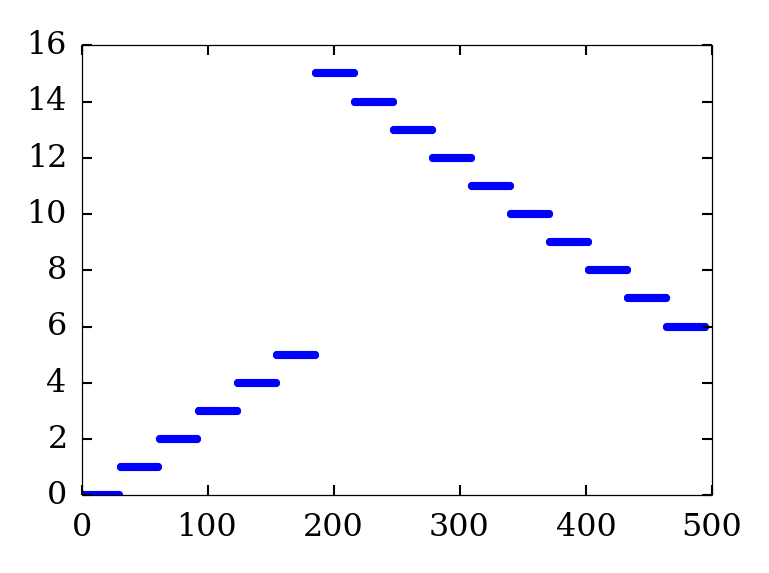

In [15]:
plt.plot(sg.index, '.')

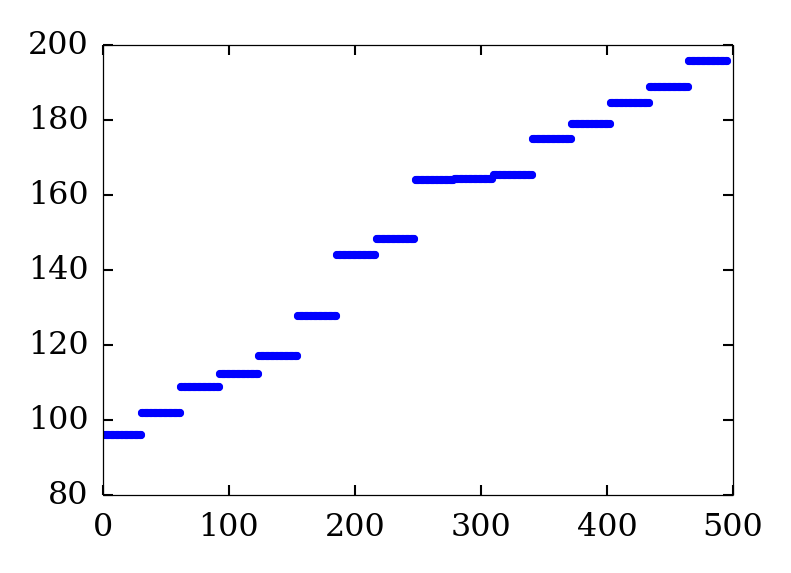

In [16]:
plt.plot(sg.frequency, '.')

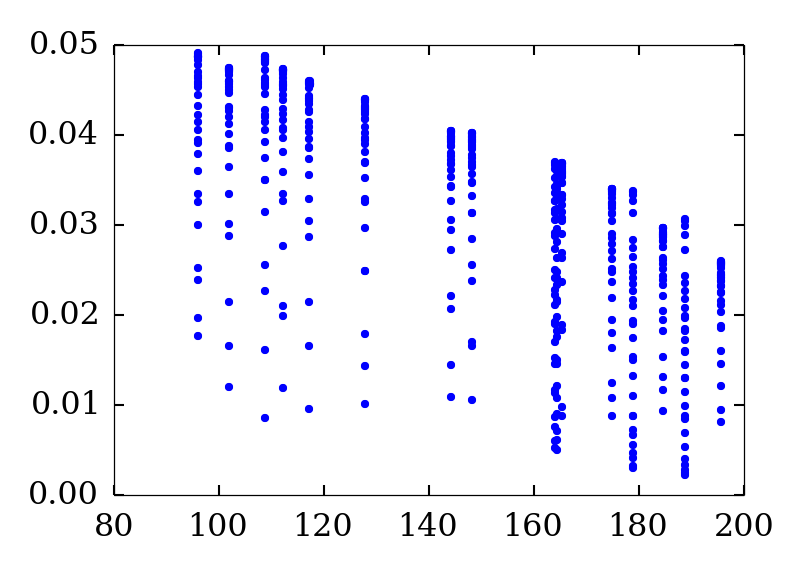

In [18]:
plt.plot(sg.frequency, np.abs(sg.s21), '.')

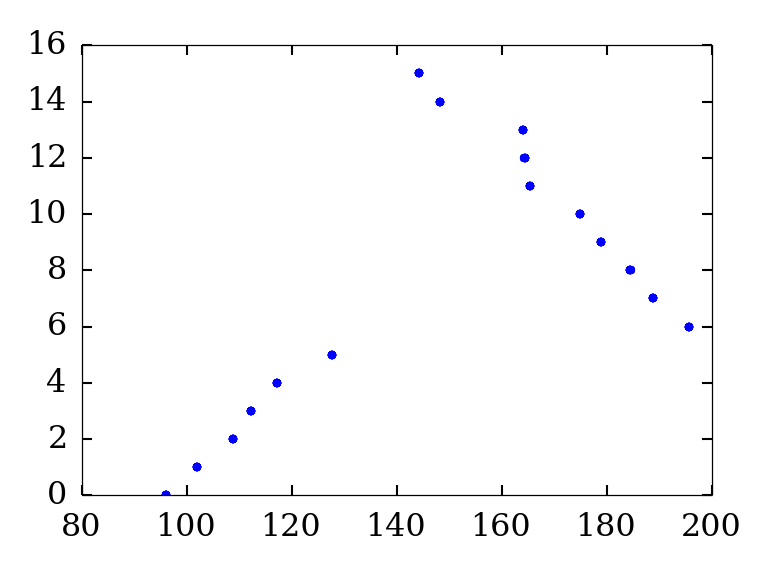

In [8]:
plt.plot(sg.frequency, sg.index, '.')

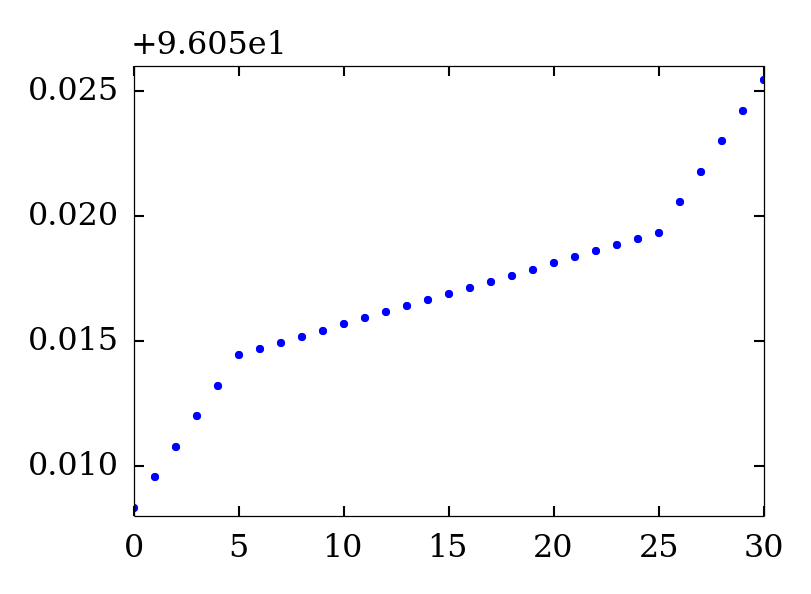

In [10]:
plt.plot(sg.frequency[sg.index==0], '.')

In [11]:
sg.s21.shape

(496,)

In [12]:
n_channels = np.unique(sg.index).size
n_channels

16

In [13]:
frequencies_per_index = int(sg.frequency.size / n_channels)
frequencies_per_index

31

In [14]:
n_channels * frequencies_per_index

496

In [7]:
sg.frequency[::frequencies_per_index]

array([  96.05834961,  101.95605469,  108.85839844,  112.25634766,
        117.26611328,  127.78051758,  144.18383789,  148.24121094,
        164.07910156,  164.37036133,  165.40405273,  174.95166016,
        178.93701172,  184.55004883,  188.85839844,  195.70825195])

In [8]:
sg.timestream_group.epoch.shape

(496,)

In [10]:
sg.timestream_group.epoch[::frequencies_per_index] - sg.timestream_group.epoch.min()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [11]:
sg.timestream_group.epoch[:n_channels] - sg.timestream_group.epoch.min()

array([  0.        ,   0.77221608,   1.55145311,   2.32473993,
         3.10197496,   3.88138914,   4.65785098,   5.43400812,
         6.20880294,   6.98333216,   7.75915909,   8.53130603,
         9.30900908,  10.07941198,  10.84969902,  11.61490512])

In [12]:
sg.timestream_group.data_len_seconds[0]

0.52428799999999998

In [14]:
np.all(sg.timestream_group.data_len_seconds == sg.timestream_group.data_len_seconds[0])

True

In [15]:
sg.s21.shape

(496,)

# Index mysteries

In [ ]:
sg.index.shape

In [18]:
# Why does this not correspond to the frequency order?
sg.index[::frequencies_per_index]

array([ 0,  1,  2,  3,  4,  5, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6], dtype=int32)

In [21]:
sg.frequency[::frequencies_per_index]

array([  96.05834961,  101.95605469,  108.85839844,  112.25634766,
        117.26611328,  127.78051758,  144.18383789,  148.24121094,
        164.07910156,  164.37036133,  165.40405273,  174.95166016,
        178.93701172,  184.55004883,  188.85839844,  195.70825195])

In [19]:
sg.timestream_group.data.shape

(496, 8192)

In [31]:
np.all(sg_on.frequency == sg_on.timestream_group.measurement_freq)

True

In [28]:
sg.index[6 * frequencies_per_index:(6+1) * frequencies_per_index]

array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15], dtype=int32)